# FINE-TUNING ZOOBOT MODELS

This notebook demonstrates finetuning Zoobot.

Finetuning means adapting a model pretrained on a large amount of data (here, many Galaxy Zoo answers) to solve a new problem using a small amount of new data.

We follow these steps:
- Install Zoobot (PyTorch version)
- Download the data to finetune on, starting from that checkpoint and the data to finetune on (ring images and ring label catalog)
- Download a pretrained checkpoint from HuggingFace
- Configure and run the finetuning

For standalone script examples, see zoobot/pytorch/examples/finetuning

## Setup

Loading Libraries

In [2]:
# prompt: automatic reload

%load_ext autoreload
%autoreload 2

In [3]:
import logging
import os
import sys

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

In [4]:
import torch
torch.__version__

'2.6.0+cu124'

In [92]:
ROOT_DIR = Path().resolve().parent
DATA_DIR = ROOT_DIR / 'data'
RGB_DATA_DIR = DATA_DIR / 'raw' / 'galaxies-rgb'

RGB_DATA_DIR

PosixPath('/home/rmegret/galaxy/galaxy-classification/data/raw/galaxies-rgb')

In [ ]:
# Download galaxies-rgb dataset and unpack it as data/raw/galaxies-rgb/
#!wget -nc galaxies-rgb.zip https://storage.googleapis.com/galaxies-rgb/galaxies-rgb.zip
!tar -xzvf {DATA_DIR}/galaxies-rgb.tar.gz -C {DATA_DIR / 'raw'}

## Install Zoobot

In [ ]:
#!pip install zoobot[pytorch-colab] -q

Now we're set up and can start using Zoobot.

## Download Catalogs of Images and Labels

Each catalog should be a dataframe with columns of "id_str", "file_loc", and any labels.

The catalog must have:
- Column(s) with your labels e.g. bool `galaxy`.
- `id_str` to identify each row. Can be anything unique.
- `file_loc` column with paths to each image (.jpg, .png and .fits are supported - see the docs)


## Use ready_made splits

In [105]:
# Reload ready made split
catalog = pd.read_csv(RGB_DATA_DIR / 'catalog_with_split.csv', index_col=0)

catalog['file_loc'] = catalog['file_loc'].apply(lambda x: str(RGB_DATA_DIR / x))   # Redefine file_loc to have full path

train_catalog = catalog[catalog.train == 1]
test_catalog = catalog[catalog.train == 0]
print(f"Training set size: {len(train_catalog)}")
print(f"Testing set size: {len(test_catalog)}")

label_cols = ['galaxy']

Training set size: 1140
Testing set size: 285


In [106]:
# Check if all files exist
assert all([os.path.isfile(loc) for loc in train_catalog['file_loc']])

In [103]:
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule

import albumentations as A
import cv2
import numpy as np

from galaxy_datasets.transforms import base_transforms

class RandomCenteredCrop(A.ImageOnlyTransform):
    def __init__(self, size=(224,224), scale=(0.8, 1.2), rotation=(-180,180), p=1.0, seed=43):
        super().__init__(p=p)
        self.size = size
        self.scale = scale
        self.rotation = rotation
        self.seed = seed
        self.random_generator = np.random.RandomState(seed)

    def get_transform_init_args_names(self):
        return ("size", "scale", "rotation", "p", "seed")
    
    def apply(self, img, **params):
        h,w = img.shape[:2]
        scale = self.random_generator.uniform(self.scale[0], self.scale[1])  # Random scale factor
        angle = self.random_generator.uniform(self.rotation[0], self.rotation[1])  # Random rotation

        # Compute center of the original image
        center = (w / 2, h / 2)

        # Create affine transformation matrix for scaling and rotation
        M = cv2.getRotationMatrix2D(center, angle, scale)

        # Translate the center to output size/2
        M[0, 2] += self.size[1] / 2 - center[0]
        M[1, 2] += self.size[0] / 2 - center[1]

        # Apply warp transformation (scaling + rotation)
        warped_img = cv2.warpAffine(img, M, (self.size[1],self.size[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

        #print(warped_img.shape)
        return warped_img
    
class KeepCenterOnly(A.ImageOnlyTransform):
    def __init__(self, size=(224,224), radius=40, kernel="disk", p=1.0):
        super().__init__(p=p)
        self.size = size
        self.radius = radius
        self.kernel = kernel
        
        self.mask = self.generate_mask(radius, kernel)

    def get_transform_init_args_names(self):
        return ("size", "radius", "kernel")
    
    def generate_mask(self, radius, kernel):
        # Create a grid of coordinates
        y, x = np.indices((self.size[0], self.size[1]))
        
        # Calculate the center of the image
        center_y, center_x = self.size[0] // 2, self.size[1] // 2
        
        # Compute the Euclidean distance to the center
        if (self.kernel == "gaussian"):
            sigma = self.radius * 2
            mask = np.exp( - ((x - center_x)**2 + (y - center_y)**2) / 2.0 / sigma**2 )
        elif (self.kernel == "disk"):
            mask = ((x - center_x)**2 + (y - center_y)**2) < (self.radius ** 2)

        return mask

    def apply(self, img, **params):
        return (img * self.mask[:,:,np.newaxis]).astype(np.uint8)

def custom_transforms(
    crop_scale_bounds=(0.7, 0.8),
    rotation_bounds=(-180.0,180.0),
    resize_after_crop=224, 
    pytorch_greyscale=False,
    to_float=True  # set to True when loading images directly, False via webdatasets (which normalizes to 0-1 on decode)
    ) -> A.Compose:

    transforms_to_apply = base_transforms(pytorch_greyscale)

    transforms_to_apply += [
        # A.ToFloat(),
        # anything outside of the original image is set to 0.
        #A.Rotate(limit=180, interpolation=1, border_mode=0, fill=0),
        RandomCenteredCrop(size=(resize_after_crop,resize_after_crop), scale=crop_scale_bounds, rotation=rotation_bounds),
        # A.RandomResizedCrop(
        #     size=(resize_after_crop,resize_after_crop),  # after crop resize
        #     scale=crop_scale_bounds,  # crop factor
        #     ratio=crop_ratio_bounds,  # crop aspect ratio
        #     interpolation=1,  # This is "INTER_LINEAR" == BILINEAR interpolation. See: https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html
        # ),  # new aspect ratio
        A.VerticalFlip(p=0.5),
        KeepCenterOnly(size=(resize_after_crop,resize_after_crop), radius=40),
    ]
    if to_float:
        transforms_to_apply += [A.ToFloat(max_value=255.0)]

    return A.Compose(transforms_to_apply)

In [67]:
datamodule = GalaxyDataModule(
    label_cols=label_cols,  # specifying which columns to load as labels with `label_cols`
    catalog=train_catalog, 
    train_fraction=0.8,
    val_fraction=0.19,
    test_fraction=0.01,
    batch_size=48,
    resize_after_crop=224,  # the size of the images input to the model
    num_workers=2,  # sets the parallelism for loading data. 2 works well on colab.
    greyscale=False,  # Most Zoobot checkpoints expect color images
    custom_albumentation_transform=custom_transforms(),
)
print(datamodule.custom_albumentation_transform)

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using the same custom albumentations transforms for train and test


Compose([
  Lambda(name='RemoveAlpha', image=<galaxy_datasets.transforms.RemoveAlpha object at 0x7f4a37633cd0>, mask=<function noop at 0x7f4aa853bac0>, keypoints=<function noop at 0x7f4aa853bac0>, bboxes=<function noop at 0x7f4aa853bac0>, p=1.0),
  RandomCenteredCrop(p=1.0, size=(224, 224), scale=(0.7, 0.8), rotation=(-180.0, 180.0)),
  VerticalFlip(p=0.5),
  KeepCenterOnly(p=1.0, size=(224, 224), radius=40, kernel='disk'),
  ToFloat(p=1.0, max_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


### Debug datamodule

INFO:lightning_fabric.utilities.seed:Seed set to 42


tensor(0.) tensor(1.) torch.Size([32, 3, 224, 224])
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
        0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.])


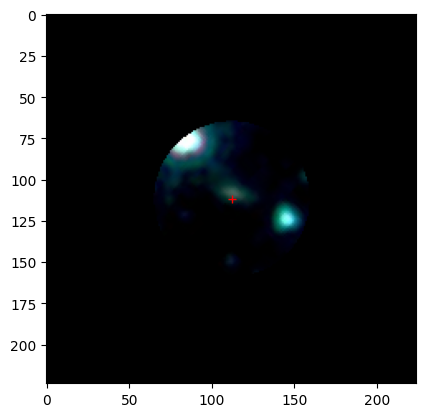

In [19]:
import pytorch_lightning as pl

# just to demonstrate what datamodule returns. you don't need to do this.
datamodule.setup()
pl.seed_everything(42)
for batch in datamodule.train_dataloader():
  images = batch[0]
  labels = batch[1]
  print(images.min(), images.max(), images.shape)
  print(labels)
  plt.imshow(batch[0][2].permute(1, 2, 0))
  plt.plot(112,112, '+', color='red')
  break

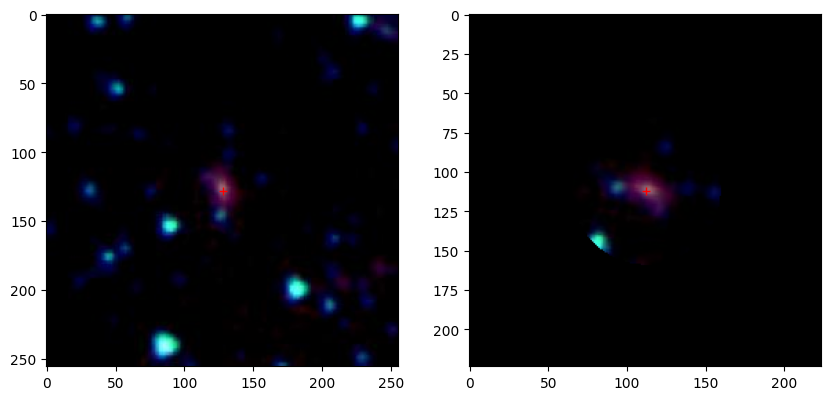

In [20]:
# Test augmentation
import matplotlib.pyplot as plt
from PIL import Image

galaxy = train_catalog.iloc[810]
im = Image.open(galaxy['file_loc'])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(im)
axes[0].plot(128,128, '+', color='red')
imaug=custom_transforms(crop_scale_bounds=(1.0,1.0))(image=np.array(im))['image']
axes[1].imshow(imaug)
axes[1].plot(112,112, '+', color='red')

In [39]:
imaug.max()

np.float32(216.61867)

# Do finetuning

In [ ]:
RUN_DIR = DATA_DIR / 'runs' / 'rgb-center'
RUN_DIR.mkdir(parents=True, exist_ok=True)

In [112]:
# Define the dataset to work on and loading parameters

transforms = custom_transforms()

datamodule = GalaxyDataModule(
    label_cols=label_cols,  # specifying which columns to load as labels with `label_cols`
    catalog=train_catalog, 
    train_fraction=0.8,
    val_fraction=0.19,
    test_fraction=0.01,
    batch_size=48,
    resize_after_crop=224,  # the size of the images input to the model
    num_workers=2,  # sets the parallelism for loading data. 2 works well on colab.
    greyscale=False,  # Most Zoobot checkpoints expect color images
    custom_albumentation_transform=transforms,
)
print(datamodule.custom_albumentation_transform)
A.save(datamodule.custom_albumentation_transform, RUN_DIR / 'transform.yaml', 'yaml')

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using the same custom albumentations transforms for train and test


Compose([
  Lambda(name='RemoveAlpha', image=<galaxy_datasets.transforms.RemoveAlpha object at 0x7f4a323b3130>, mask=<function noop at 0x7f4aa853bac0>, keypoints=<function noop at 0x7f4aa853bac0>, bboxes=<function noop at 0x7f4aa853bac0>, p=1.0),
  RandomCenteredCrop(p=1.0, size=(224, 224), scale=(0.7, 0.8), rotation=(-180.0, 180.0)),
  VerticalFlip(p=0.5),
  KeepCenterOnly(p=1.0, size=(224, 224), radius=40, kernel='disk'),
  ToFloat(p=1.0, max_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [ ]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier

model = FinetuneableZoobotClassifier(
    # arguments for any FinetuneableZoobot class
    # there are many options for customizing finetuning. See the FinetuneableZoobotAbstract docstring.
    name='hf_hub:mwalmsley/zoobot-encoder-convnext_nano',  # name of the model to load from the Hugging Face model hub
    n_blocks=5,  # Finetune this many blocks. Set 0 for only the head. Set e.g. 1, 2 to finetune deeper (5 max for convnext).
    learning_rate=1e-5,  # use a low learning rate
    lr_decay=0.5,  # reduce the learning rate from lr to lr^0.5 for each block deeper in the network

    # arguments specific to FinetuneableZoobotClassifier
    num_classes=2
)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (mwalmsley/zoobot-encoder-convnext_small)
INFO:root:Using classification head and cross-entropy loss
INFO:root:num_classes: 2
INFO:root:Using binary classification


In [ ]:
# TRAIN
from zoobot.pytorch.training.finetune import get_trainer
trainer = get_trainer(RUN_DIR, accelerator='auto', devices='auto', max_epochs=30, log_every_n_steps=1)
trainer.fit(model, datamodule)

## Predict on test set

In [ ]:
# now we can load the best checkpoint and make predictions
best_checkpoint = trainer.checkpoint_callback.best_model_path
#best_checkpoint = RUN_DIR / 'checkpoints/19.ckpt'
print(best_checkpoint)
finetuned_model = FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

/home/rmegret/galaxy/galaxy-classification/data/runs/rgb-center-crop-windowed/checkpoints/19.ckpt


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (mwalmsley/zoobot-encoder-convnext_nano)
INFO:root:Using classification head and cross-entropy loss
INFO:root:num_classes: 2
INFO:root:Using binary classification


In [52]:
from zoobot.pytorch.predictions import predict_on_catalog

_ = predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=1,
  # CAREFUL! For classification, we unpack a single column like [1, 0, 1, 2, ...] into N classes automatically
  # but when making predictions, we make a prediction per class, so (unlike for training) this prediction `label_cols` needs n_classes entries
  # e.g. [class_for_label_0, class_for_label_1, ...
  label_cols=['not_galaxy', 'galaxy'],  # name the output columns
  save_loc = str(RUN_DIR / 'finetuned_predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using basic albumentations transforms for augmentations
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:root:Beginning predictions
INFO:root:Starting at: 2025-03-22 18:27:50
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:01<00:00,  7.97it/s]


INFO:root:Predictions complete - (285, 2, 1)
INFO:root:Saving predictions to /home/rmegret/galaxy/galaxy-classification/data/runs/rgb-center-crop-windowed/finetuned_predictions.csv
INFO:root:Predictions saved to /home/rmegret/galaxy/galaxy-classification/data/runs/rgb-center-crop-windowed/finetuned_predictions.csv
INFO:root:Completed at: 2025-03-22 18:27:51
INFO:root:Time elapsed: 0:00:01.441557


Let's quickly check if they're any good:

In [31]:
predictions = pd.read_csv( RUN_DIR / 'finetuned_predictions.csv' )
print(predictions.shape[0])
predictions = pd.merge(predictions, test_catalog[['id_str', 'file_loc', 'galaxy']])
predictions.head()

285


,id_str,not_galaxy_pred,galaxy_pred,file_loc,galaxy
0,"104.7263830,2.0560720_10450_0145",0.582466,0.417534,/home/rmegret/galaxy/galaxy-classification/dat...,True
1,"104.3578369,1.5539122_10450_0145",0.741620,0.258380,/home/rmegret/galaxy/galaxy-classification/dat...,True
2,"104.0930341,1.3333430_10450_0145",0.650094,0.349906,/home/rmegret/galaxy/galaxy-classification/dat...,True
3,"104.8807827,0.9197180_10450_0145",0.524250,0.475750,/home/rmegret/galaxy/galaxy-classification/dat...,True
4,"104.4275534,1.6589155_10450_0145",0.167385,0.832615,/home/rmegret/galaxy/galaxy-classification/dat...,True


In [55]:
#import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
print('Accuracy:', np.mean(np.around(predictions['galaxy_pred']) == predictions['galaxy']))

Accuracy: 0.6947368421052632


Text(0.5, 0, 'predicted score')

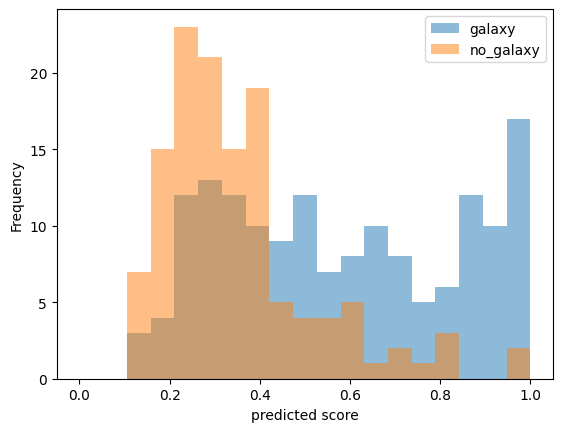

In [33]:
pp = predictions.copy()
pp['galaxy']=pp['galaxy'].astype(float)
pp[pp.galaxy==1]['galaxy_pred'].rename('galaxy').plot.hist(bins=np.linspace(0,1, 20), alpha=0.5);
pp[pp.galaxy==0]['galaxy_pred'].rename('no_galaxy').plot.hist(bins=np.linspace(0,1, 20), alpha=0.5);
plt.legend()
plt.xlabel('predicted score')

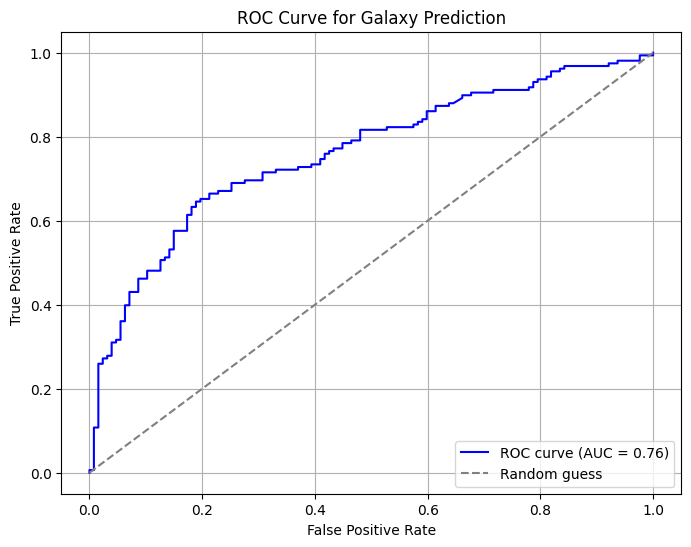

In [34]:
from sklearn.metrics import roc_curve, auc

true_labels = predictions['galaxy'].astype(int)  # Convert boolean to integer
predicted_probs = predictions['galaxy_pred']

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Galaxy Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [35]:
print(train_catalog.shape[0])
print(test_catalog.shape[0])
print(predictions.shape[0])

1140
285
285


## Predict on training set

In [36]:
# Do same on training to sort out difficulty levels

_ = predict_on_catalog.predict(
  train_catalog,
  finetuned_model,
  n_samples=1,
  # CAREFUL! For classification, we unpack a single column like [1, 0, 1, 2, ...] into N classes automatically
  # but when making predictions, we make a prediction per class, so (unlike for training) this prediction `label_cols` needs n_classes entries
  # e.g. [class_for_label_0, class_for_label_1, ...
  label_cols=['not_galaxy', 'galaxy'],  # name the output columns
  save_loc= str( RUN_DIR / 'finetuned_predictions_train_dataset.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using basic albumentations transforms for augmentations
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:root:Beginning predictions
INFO:root:Starting at: 2025-03-22 18:15:09
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 36/36 [00:02<00:00, 12.21it/s]


INFO:root:Predictions complete - (1140, 2, 1)
INFO:root:Saving predictions to /home/rmegret/galaxy/galaxy-classification/data/runs/rgb-center-crop-windowed/finetuned_predictions_train_dataset.csv
INFO:root:Predictions saved to /home/rmegret/galaxy/galaxy-classification/data/runs/rgb-center-crop-windowed/finetuned_predictions_train_dataset.csv
INFO:root:Completed at: 2025-03-22 18:15:12
INFO:root:Time elapsed: 0:00:03.499980


In [37]:
predictions_training = pd.read_csv( RUN_DIR / 'finetuned_predictions_train_dataset.csv' )
print(predictions_training.shape[0])

predictions_training = pd.merge(predictions_training, train_catalog[['id_str', 'file_loc', 'galaxy']])
print(predictions_training.shape[0])

predictions_training.head()

1140
1140


,id_str,not_galaxy_pred,galaxy_pred,file_loc,galaxy
0,"104.1504793,1.3987231_10450_0145",0.438195,0.561805,/home/rmegret/galaxy/galaxy-classification/dat...,True
1,"104.9237340,1.5302104_10450_0145",0.715369,0.284631,/home/rmegret/galaxy/galaxy-classification/dat...,True
2,"104.7788009,1.1385662_10450_0145",0.528985,0.471015,/home/rmegret/galaxy/galaxy-classification/dat...,True
3,"104.8010448,1.6888967_10450_0145",0.303723,0.696277,/home/rmegret/galaxy/galaxy-classification/dat...,True
4,"104.0695201,1.9894318_10450_0145",0.393176,0.606824,/home/rmegret/galaxy/galaxy-classification/dat...,True


## Display results

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_rings(df, nrows=None, ncols=5):
  # little utility function to visualise galaxies and our ring labels/predictions

  N = df.shape[0]
  #print(N)
  if (nrows is None):
    nrows = (N+ncols-1)//ncols
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
  axes = axes.ravel()
  for n in range(ncols*nrows):
    axes[n].axis('off')
    if (n>=N): continue;
    galaxy = df.iloc[n]

    im = Image.open(galaxy['file_loc'])
    axes[n].imshow(im)

    correct = np.around(galaxy['galaxy_pred']) == galaxy['galaxy']
    if correct:
      color = 'g'
    else:
      color = 'r'
    axes[n].text(20, 30, 'Pred: {:.2f}'.format(galaxy['galaxy_pred']), color=color)
    axes[n].text(20, 60, 'Label: {}'.format(galaxy['galaxy']), color=color)
    axes[n].plot([130,230],[20,20],color=color)
    axes[n].plot([130+100*galaxy['galaxy']],[25],'^',color='g')
    axes[n].plot([130+100*galaxy['galaxy_pred']],[20],'o',color=color)
    axes[n].text(130, 40, 'Err {:.2f}'.format(abs(galaxy['galaxy']-galaxy['galaxy_pred'])), color=color)
    axes[n].text(10,240, galaxy['id_str'], color=color, size=7)
    axes[n].set_title(f"#{int(galaxy.name)}: {galaxy['id_str']}", size=7)
  return fig, axes

### Display sampled predictions

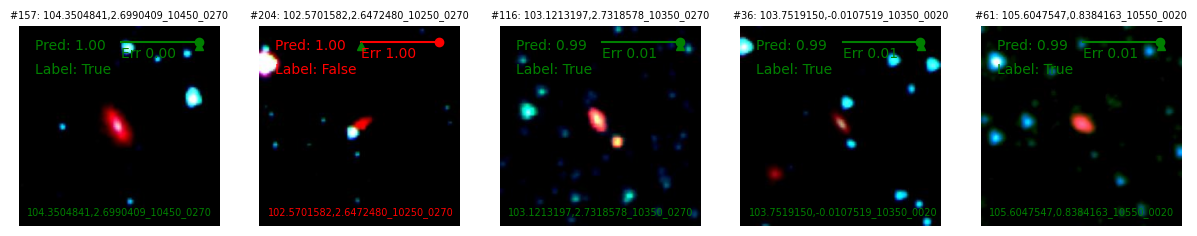

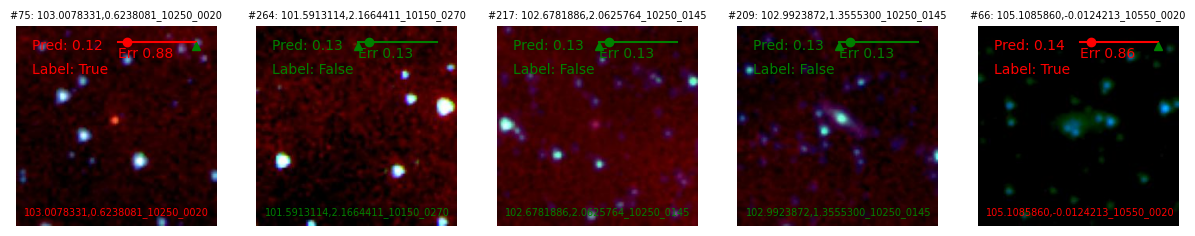

In [41]:
top_predictions = predictions.sort_values('galaxy_pred', ascending=False)
show_rings(top_predictions, nrows = 1)

bottom_predictions = predictions.sort_values('galaxy_pred', ascending=True)
show_rings(bottom_predictions, nrows = 1);

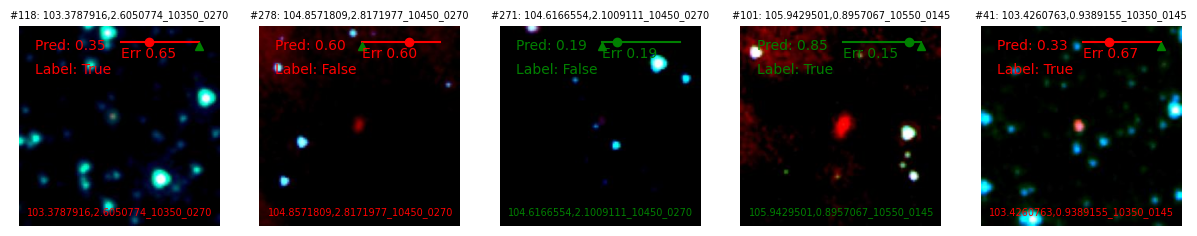

In [43]:
random_predictions = predictions.sample(5)
show_rings(random_predictions, nrows=1);

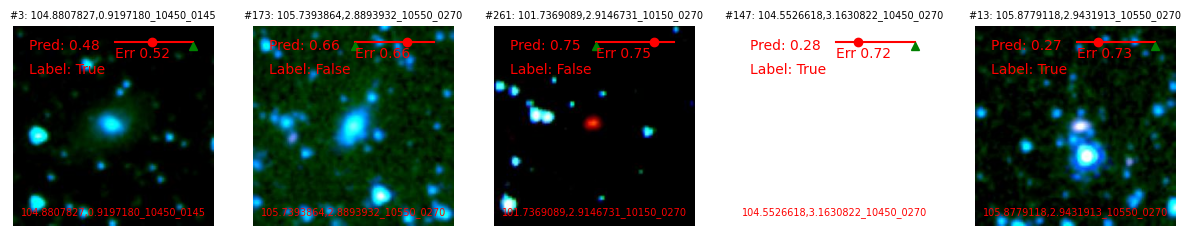

In [46]:
wrong_predictions = predictions.loc[(predictions['galaxy_pred']>0.5) != predictions['galaxy']]
random_predictions = wrong_predictions.sample(5)
show_rings(random_predictions);
#print(random_predictions['id_str'])

### Generate PDF files of all predictions

In [47]:
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

pdf_filename = RUN_DIR / "predictions_test.pdf"

predictions_sorted = predictions.sort_values('galaxy_pred', ascending=False)
N = predictions_sorted.shape[0]
n_per_page = 25
k_pages = (N+n_per_page-1)//n_per_page
#k_pages = 1
with PdfPages(pdf_filename) as pdf:
  for k in tqdm(range(k_pages)):
    n1 = k*n_per_page
    fig, axes = show_rings(predictions_sorted.iloc[n1:], nrows=5, ncols=8)
    #print(top_5_predictions['id_str'])
    fig.suptitle(f'TEST DATA: Sorted by prediction score - Page {k+1}/{k_pages} - {n1}..{min(N,n1+n_per_page-1)}/0..{N-1}', fontsize=16)
    fig.tight_layout()
    pdf.savefig()
    plt.close()

100%|██████████| 12/12 [00:23<00:00,  1.98s/it]


In [53]:
pdf_filename = RUN_DIR / "predictions_test_error.pdf"

p_df = predictions.copy()
p_df['pred_error'] = np.abs(p_df['galaxy']-p_df['galaxy_pred'])
predictions_sorted = p_df.sort_values('pred_error', ascending=False)
N = predictions_sorted.shape[0]
n_per_page = 25
k_pages = (N+n_per_page-1)//n_per_page
#k_pages = 1
with PdfPages(pdf_filename) as pdf:
  for k in tqdm(range(k_pages)):
    n1 = k*n_per_page
    fig, axes = show_rings(predictions_sorted.iloc[n1:], nrows=5, ncols=8)
    #print(top_5_predictions['id_str'])
    fig.suptitle(f'TEST DATA: Sorted by prediction error - {k+1}/{k_pages} - {n1}..{min(N,n1+n_per_page-1)}/0..{N-1}', fontsize=16)
    fig.tight_layout()
    pdf.savefig()
    plt.close()

100%|██████████| 12/12 [00:25<00:00,  2.10s/it]


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

# Save predictions on training sorted by score

pdf_filename = RUN_DIR / "predictions_training.pdf"

predictions_sorted = predictions_training.sort_values('galaxy_pred', ascending=False)
N = predictions_sorted.shape[0]
n_per_page = 25
k_pages = (N+n_per_page-1)//n_per_page
#k_pages = 1
with PdfPages(pdf_filename) as pdf:
  for k in tqdm(range(k_pages)):
    n1 = k*n_per_page
    fig, axes = show_rings(predictions_sorted.iloc[n1:], nrows=5, ncols=8)
    #print(top_5_predictions['id_str'])
    fig.suptitle(f'TRAIN DATA - Sorted by prediction score - Page {k+1}/{k_pages} - {n1}..{min(N,n1+n_per_page-1)}/0..{N-1}', fontsize=16)
    fig.tight_layout()
    pdf.savefig()
    plt.close()